In [1]:
import pandas as pd
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from matplotlib import gridspec
import seaborn as sns
import copy

In [2]:
from scipy import stats
from scipy import sparse

In [3]:
from functools import partial

In [4]:
import mne
from mne.stats import (ttest_1samp_no_p, bonferroni_correction, fdr_correction,
                       permutation_t_test, permutation_cluster_1samp_test)

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [6]:
import matplotlib.pyplot as plt
font = {'family': 'sans-serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [7]:
label_fontsize = 16 
title_fontsize = 18

In [8]:
sns.set(style="ticks", rc={"lines.linewidth": 0.6})

In [9]:
basefilelist = [#"11072018_SponSleep_LFP"   #-- 1(No calib), 
                 "27072018_SponSleep_LFP",  #-- 2
                 "14092018_SponSleep_LFP",  #-- 3
                 "17092018_SponSleep_LFP",  #-- 4
                #"19092018_SponSleep_LFP",  #-- 5(Noisy calib)
                 "30102018_SponSleep_LFP",  #-- 6
                 "01112018_SponSleep_LFP",  #-- 7
                 "03112018_SponSleep_LFP",  #-- 8
                 "13112018_SponSleep_LFP",  #-- 9 
                #"21112018_SponSleep_LFP",  #-- 10(Very little sleep trials)
                #"22112018_SponSleep_LFP",  #-- 11(Very Noisy calib)
                 "28112018_SponSleep_LFP",  #-- 12(Very little sleep trials)
                #"29112018_SponSleep_LFP",  #-- 13(Inactive after 4 hours)
                 "11122018_SponSleep_LFP",  #-- 14
                # "13122018_SponSleep_LFP",  #-- 15(Very awake fly)
                # "18122018_SponSleep_LFP",  #-- 16(no sleep proboscis periods)
                 "10012019_SponSleep_LFP",  #-- 17
                 "17012019_SponSleep_LFP",  #-- 18
                 "22012019_SponSleep_LFP",  #-- 19
                #"07022019_SponSleep_LFP",  #-- 20(No sleep data)
                 "20022019_SponSleep_LFP",  #-- 21
                #"06032019_SponSleep_LFP",  #-- 22(Noisy calib)
                # "13032019_SponSleep_LFP",  #-- 23
                ]

In [10]:
n_flies = len(basefilelist)
print("Total files considered: " + str(n_flies))

Total files considered: 13


In [11]:
reference = 'neutral' #'neutral','diff'

In [12]:
basefolder = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/"
inputfolderpath = basefolder + "drosSleepStages_SciAdvances2023/data/lfp_data/spectrum_proboscis/"

In [13]:
def loadspectrumdata(spectfilebasename, probosciscat = None, controlcat = None):
    
    proboscisfilepath = inputfolderpath + "Spectrum_proboscis_" + reference + "_ref_" + spectfilebasename + ".mat"
    
    controlfilepath = inputfolderpath + "Spectrum_controlproboscis_" + reference + "_ref_" + spectfilebasename + ".mat"
    
    mat_probspectrum = io.loadmat(proboscisfilepath)
    
    mat_controlspectrum = io.loadmat(controlfilepath)
    
    if probosciscat is None:
        cat1_mean = (mat_controlspectrum['chan_cat1_mean'])
        cat2_mean = (mat_controlspectrum['chan_cat2_mean'])
        cat1_size = np.asscalar(mat_controlspectrum['cat1_size'])
        cat2_size = np.asscalar(mat_controlspectrum['cat2_size'])
        cat1_se = mat_controlspectrum['chan_cat1_se']
        cat2_se = mat_controlspectrum['chan_cat2_se']
        cat_freqs = mat_controlspectrum['plotfreqs_state']
        cat_state = np.hstack(mat_controlspectrum['state'].flatten()).tolist()
    elif controlcat is None:
        cat1_mean = (mat_probspectrum['chan_cat1_mean'])
        cat2_mean = (mat_probspectrum['chan_cat2_mean'])
        cat1_size = np.asscalar(mat_probspectrum['cat1_size'])
        cat2_size = np.asscalar(mat_probspectrum['cat2_size'])
        cat1_se = mat_probspectrum['chan_cat1_se']
        cat2_se = mat_probspectrum['chan_cat2_se']
        cat_freqs = mat_probspectrum['plotfreqs_state']
        cat_state = np.hstack(mat_probspectrum['state'].flatten()).tolist()
    else:
        cat_controlstates = np.hstack(mat_controlspectrum['state'].flatten()).tolist()
        cat_probstates = np.hstack(mat_probspectrum['state'].flatten()).tolist()
        controlindex = cat_controlstates.index(controlcat)
        probindex = cat_probstates.index(probosciscat)
        cat_freqs = mat_controlspectrum['plotfreqs_state']
        
        cat_state=[]
        cat_state.append(cat_controlstates[controlindex])
        cat_state.append(cat_probstates[probindex])
        
        if controlindex == 0:
            controlcat_mean = (mat_controlspectrum['chan_cat1_mean'])
            controlcat_size = np.asscalar(mat_controlspectrum['cat1_size'])
            controlcat_se = mat_controlspectrum['chan_cat1_se']
        else:
            controlcat_mean = (mat_controlspectrum['chan_cat2_mean'])
            controlcat_size = np.asscalar(mat_controlspectrum['cat2_size'])
            controlcat_se = mat_controlspectrum['chan_cat2_se']
            
        if probindex == 0:
            probcat_mean = (mat_probspectrum['chan_cat1_mean'])
            probcat_size = np.asscalar(mat_probspectrum['cat1_size'])
            probcat_se = mat_probspectrum['chan_cat1_se']
        else:
            probcat_mean = (mat_probspectrum['chan_cat2_mean'])
            probcat_size = np.asscalar(mat_probspectrum['cat2_size'])
            probcat_se = mat_probspectrum['chan_cat2_se']
            
        cat1_mean = controlcat_mean
        cat1_se = controlcat_se
        cat1_size = controlcat_size
        
        cat2_mean = probcat_mean
        cat2_se = probcat_se
        cat2_size = probcat_size
        
    return cat1_mean,cat1_se,cat1_size,cat2_mean,cat2_se,cat2_size,cat_state,cat_freqs     

In [14]:
def computegrp_withinstates(prob_cat, ctrl_cat):
    
    diff_list = []
    group_cat1 = []
    group_cat2 = []
    group_cat1size = []
    group_cat2size = []
    for basefileidx in range(len(basefilelist)): #len(basefilelist)
        basefilename = basefilelist[basefileidx]

        print('Processing: ', basefilename)

        cat1_mean,cat1_se,cat1_size,\
        cat2_mean,cat2_se,cat2_size,\
        cat_state,cat_freqs = loadspectrumdata(basefilename, prob_cat, ctrl_cat)


        if len(cat1_mean)>0 and len(cat2_mean)>0:
            if cat1_size >=50 and cat2_size >= 50:
                diff_cat = cat2_mean - cat1_mean
                diff_list.append(diff_cat)
                group_cat1.append(cat1_mean)
                group_cat2.append(cat2_mean)
                group_cat1size.append(cat1_size)
                group_cat2size.append(cat2_size)
                print("Cat1: ", cat_state[0],  " -- size: " + str(cat1_size))
                print("Cat2: ", cat_state[1],  " -- size: " + str(cat2_size))

            else:
                print("Skipping: " + basefilename)
        else:
            print("Skipping: " + basefilename)
            
    return diff_list, group_cat1, group_cat2, group_cat1size, group_cat2size, cat_state,cat_freqs

In [15]:
def computegrp_acrossstates(prob_cat1, ctrl_cat1, prob_cat2, ctrl_cat2):
    
    diff_list = []
    group_cat1 = []
    group_cat2 = []
    group_cat1size = []
    group_cat2size = []
    for basefileidx in range(len(basefilelist)): #len(basefilelist)
        basefilename = basefilelist[basefileidx]

        print('Processing: ', basefilename)

        probcat1_mean,probcat1_se,probcat1_size,\
        ctrlcat1_mean,ctrlcat1_se,ctrlcat1_size,\
        cat_state1,cat_freqs1 = loadspectrumdata(basefilename, prob_cat1, ctrl_cat1)
        
        probcat2_mean,probcat2_se,probcat2_size,\
        ctrlcat2_mean,ctrlcat2_se,ctrlcat2_size,\
        cat_state2,cat_freqs2 = loadspectrumdata(basefilename, prob_cat2, ctrl_cat2)


        if (len(probcat1_mean)>0 and len(ctrlcat1_mean)>0 and len(probcat2_mean)>0 and len(ctrlcat2_mean)>0):
            if (probcat1_size >=50 and ctrlcat1_size >= 50 and probcat2_size >=50 and ctrlcat2_size >= 50):
                diff1_cat = probcat1_mean - ctrlcat1_mean
                diff2_cat = probcat2_mean - ctrlcat2_mean
                diff_cat  = diff2_cat - diff1_cat
                
                diff_list.append(diff_cat)
                group_cat1.append(probcat1_mean)
                group_cat2.append(probcat2_mean)
                group_cat1size.append(probcat1_size)
                group_cat2size.append(probcat2_size)
                print("Cat1: ", cat_state1[1],  " -- size: " + str(probcat1_size))
                print("Cat2: ", cat_state2[1],  " -- size: " + str(probcat2_size))
                
                cat_state = [cat_state1[1], cat_state2[1]]

            else:
                print("Skipping: " + basefilename)
        else:
            print("Skipping: " + basefilename)
            
    return diff_list, group_cat1, group_cat2, group_cat1size, group_cat2size, cat_state, cat_freqs1

In [16]:
def computegrpdiff_withinstates(probosciscat, controlcat):

    diff_list, group_cat1, group_cat2, group_cat1size, group_cat2size, cat_state,cat_freqs =\
                                   computegrp_withinstates(probosciscat, controlcat)
    
    diff_group = np.array(diff_list)
    print(diff_group.shape)
    
    group_cat1 = np.array(group_cat1)
    print(group_cat1.shape)
    
    group_cat1size = np.array(group_cat1size)
    print(group_cat1size)
    
    group_cat2 = np.array(group_cat2)
    print(group_cat2.shape)
    
    group_cat2 = np.array(group_cat2)
    print(group_cat2.shape)
    
    group_cat1mean = np.median(group_cat1, axis = 0)
    
    group_cat2mean = np.median(group_cat2, axis = 0)
    
    diff_groupmean = np.median(diff_group, axis = 0)
    print(diff_groupmean.shape)
    
    n_subjects = diff_group.shape[0]
    print('number of subjects considered: ', str(n_subjects))
    
    return diff_group, n_subjects, group_cat1mean, group_cat2mean, diff_groupmean, group_cat1, group_cat2, cat_state, cat_freqs

In [17]:
def computegrpdiff_acrossstates(probosciscat1, controlcat1, probosciscat2, controlcat2):
    
    diff_list, group_cat1, group_cat2, group_cat1size, group_cat2size, cat_state, cat_freqs =\
                                   computegrp_acrossstates(probosciscat1, controlcat1, probosciscat2, controlcat2)
    
    
    diff_group = np.array(diff_list)
    print(diff_group.shape)
    
    group_cat1 = np.array(group_cat1)
    print(group_cat1.shape)
    
    group_cat1size = np.array(group_cat1size)
    print(group_cat1size)
    
    group_cat2 = np.array(group_cat2)
    print(group_cat2.shape)
    
    group_cat2 = np.array(group_cat2)
    print(group_cat2.shape)
    
    group_cat1mean = np.median(group_cat1, axis = 0)
    
    group_cat2mean = np.median(group_cat2, axis = 0)
    
    diff_groupmean = np.median(diff_group, axis = 0)
    print(diff_groupmean.shape)
    
    n_subjects = diff_group.shape[0]
    print('number of subjects considered: ', str(n_subjects))
    
    return diff_group, n_subjects, group_cat1mean, group_cat2mean, diff_groupmean, group_cat1, group_cat2, cat_state, cat_freqs

In [18]:
def computestats(diff_group, n_subjects):
    
    X = diff_group
    print(X.shape)
    
    tempX = copy.deepcopy(X)
    print(tempX.shape)
    
    temp_subj, temp_freq, temp_chan  = tempX.shape
    n_src = temp_freq*temp_chan
    tempX.shape = (n_subjects, n_src)  # flatten the array for simplicity
    
    print(tempX.shape)
    
    sigma = 1e-3  # sigma for the "hat" method
    
    maxperm = permutation_t_test(tempX, verbose=False)[:2]
    
    # connectivity matrix contains zeros and ones to define which spatial points are connected, 
    # i.e., which electrodes are adjacent to each other
    
    
                               #1 2  3  4  5  6  7  8  9  10 11 12 13 14 15,
    connectivity =  np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],#1
                              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],#2
                              [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],#3
                              [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],#4
                              [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],#5
                              [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],#6
                              [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],#7
                              [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],#8
                              [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],#9
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],#10
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],#11
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],#12
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],#13
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],#14
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]) #15
    
    conn_sparse=sparse.csr_matrix(connectivity)
    
    print(conn_sparse.shape)
    
    alpha = 0.05
    n_permutations = 'all'
    threshold = -stats.distributions.t.ppf(alpha / 2., n_subjects - 1)
    
    
    stat_fun_hat = partial(ttest_1samp_no_p, sigma=sigma)
    t_hat, clusters, p_values, H0 = permutation_cluster_1samp_test(
                                    X, n_jobs=1, threshold=threshold, adjacency=conn_sparse,
                                    n_permutations=n_permutations, stat_fun=stat_fun_hat, buffer_size=None)
    p_hat = np.ones((temp_freq, temp_chan))
    for cl, p in zip(clusters, p_values):
        p_hat[cl] = p
        
        
    contourmask = np.where(p_hat<alpha, 1, 0)
    mask = np.where(p_hat<alpha, 1, np.nan)
    
    contourmask2 = np.where(p_hat<alpha, 0, 1)
    
    return contourmask, contourmask2, mask

In [19]:
def plot_spect(data, ax, x, y, x_label, y_label, title, vmin = None, vmax = None):
    
    im = ax.imshow(data,aspect='auto',interpolation='spline36',cmap='jet',vmin=vmin, vmax=vmax)
    
    y_mod = np.concatenate(y)
    freqs_plot = [5, 10, 15, 20, 25, 30, 35, 40]
    yticklocs = []
    for idx in freqs_plot:
        yticklocs.append(min(range(len(y_mod)), key=lambda i: abs(y_mod[i]-idx)))
    
#     yticklocs = np.arange(0,len(y)-1, step = 20)

    ytickvals = np.around(np.concatenate(y[yticklocs]))
    
    ydispvals = ['%.12g' % n for n in ytickvals]
    
    plt.yticks(yticklocs, ydispvals)
    xticklocs = np.arange(0,np.asarray(x.shape), step = 2)
    ax.set_xlim([0, np.asarray(x.shape)-1])
    tickval = np.arange(1,np.asarray(x.shape)+1, step = 2)
    plt.xticks(xticklocs, tickval)
    ax.set_xlabel(x_label, rotation=0,ha='center',va='center', fontsize=label_fontsize, labelpad=20)
    ax.set_ylabel(y_label, rotation=90,ha='center',va='center', fontsize=label_fontsize, labelpad=20)
    
    ax.invert_yaxis()

    cbar = plt.colorbar(im)
    
    plt.title(title,ha='center',va='bottom', fontsize=label_fontsize)
    
    cbar.ax.tick_params(labelsize=label_fontsize-2)

    return ax

In [20]:
def plot_clustermask(data, ax, x, y, x_label, y_label, title, contourmask = None, mask = None, vmin = None, vmax = None, cmap = 'jet'):
    
    
    xticklocs = np.arange(0,np.asarray(x.shape), step = 2)
    tickval = np.arange(1,np.asarray(x.shape)+1, step = 2)
    
    
    if mask is not None:
        
        extent = [-0.55, len(x)-0.55, -0.55, len(y)-0.55]  
        im_args = dict(interpolation='nearest', origin='lower',extent=extent, aspect='auto', vmin=vmin, vmax=vmax)
        
        
        big_mask = np.kron(contourmask, np.ones((10, 10)))
        ax.contour(big_mask, colors=["black"], extent=extent,linewidths=[.5], corner_mask=False,antialiased=True, levels=[0.5])
        masked_data = data*mask

        im1 = ax.imshow(masked_data,aspect='auto',interpolation='none',cmap=cmap,vmin=vmin, vmax=vmax, alpha = 0.5)
        cbar = fig.colorbar(im1, ax=ax)

    else:
        im = ax.imshow(data,aspect='auto',interpolation='spline36',cmap='jet',vmin=vmin, vmax=vmax)
        
    
    ax.set_xlim([0, np.asarray(x.shape)-1])
    
    
    y_mod = np.concatenate(y)
    
    freqs_plot = [5, 10, 15, 20, 25, 30, 35, 40]
    yticklocs = []
    for idx in freqs_plot:
        yticklocs.append(min(range(len(y_mod)), key=lambda i: abs(y_mod[i]-idx)))
    
#     yticklocs = np.arange(0,len(y)-1, step = 20)

    ytickvals = np.around(np.concatenate(y[yticklocs]))
      
    ydispvals = ['%.12g' % n for n in ytickvals]
    
    plt.yticks(yticklocs, ydispvals)
    
    ax.invert_yaxis()
    
    ax.set_xticks(xticklocs)
    ax.set_xticklabels(tickval)
    
    ax.set_xlabel(x_label, rotation=0,ha='center',va='center', fontsize=label_fontsize, labelpad=20)
    ax.set_ylabel(y_label, ha='center',va='center', fontsize=label_fontsize, labelpad=20)
    
    plt.title(title,ha='center',va='bottom', fontsize=label_fontsize)
    
    cbar.ax.tick_params(labelsize=label_fontsize-2)
   
    return ax

In [21]:
def computegrproi_withinstates(prob_cat, ctrl_cat, contourmask2):
    group_roi_cat1 = []
    group_roi_cat2 = []

    for basefileidx in range(len(basefilelist)): #len(basefilelist)
        basefilename = basefilelist[basefileidx]

        print('Processing: ', basefilename)


        cat1_mean,cat1_se,cat1_size,\
        cat2_mean,cat2_se,cat2_size,\
        cat_state,cat_freqs = loadspectrumdata(basefilename, prob_cat, ctrl_cat)


        roi_cat1 = np.ma.MaskedArray(cat1_mean,contourmask2)
        roi_cat1mean = roi_cat1.mean()
        roi_cat2 = np.ma.MaskedArray(cat2_mean,contourmask2)
        roi_cat2mean = roi_cat2.mean()


        if len(cat1_mean)>0 and len(cat2_mean)>0:
            if cat1_size >=50 and cat2_size >= 50:
                group_roi_cat1.append(roi_cat1mean)
                group_roi_cat2.append(roi_cat2mean)

            else:
                print("Skipping: " + basefilename)
        else:
            print("Skipping: " + basefilename)
            
    # typepal = {'awake':'r', 'awakeprob': 'g'}
    if controlcat == 'sleep':
        typepal = {ctrl_cat:'b', prob_cat: '#7b68ee'}
    elif controlcat == 'awake':
        typepal = {ctrl_cat:'r', prob_cat: '#ffa500'}
    elif controlcat is None:
        typepal = {prob_cat[0]:'r', prob_cat[1]: 'y'}
        
    
    group_roi_df = pd.DataFrame({ctrl_cat: group_roi_cat1, prob_cat: group_roi_cat2})
 
    return group_roi_df, group_roi_cat1, group_roi_cat2, typepal

In [22]:
def computegrproi_acrossstates(prob_cat1, ctrl_cat1, prob_cat2, ctrl_cat2):
    group_roi_cat1 = []
    group_roi_cat2 = []

    for basefileidx in range(len(basefilelist)): #len(basefilelist)
        basefilename = basefilelist[basefileidx]

        print('Processing: ', basefilename)
       
        probcat1_mean,probcat1_se,probcat1_size,\
        ctrlcat1_mean,ctrlcat1_se,ctrlcat1_size,\
        cat_state1,cat_freqs1 = loadspectrumdata(basefilename, prob_cat1, ctrl_cat1)
        
        probcat2_mean,probcat2_se,probcat2_size,\
        ctrlcat2_mean,ctrlcat2_se,ctrlcat2_size,\
        cat_state2,cat_freqs2 = loadspectrumdata(basefilename, prob_cat2, ctrl_cat2)

        roi_cat1 = np.ma.MaskedArray(probcat1_mean,contourmask2)
        roi_cat1mean = roi_cat1.mean()
        roi_cat2 = np.ma.MaskedArray(probcat2_mean,contourmask2)
        roi_cat2mean = roi_cat2.mean()


        if (len(probcat1_mean)>0 and len(ctrlcat1_mean)>0 and len(probcat2_mean)>0 and len(ctrlcat2_mean)>0):
            if (probcat1_size >=50 and ctrlcat1_size >= 50 and probcat2_size >=50 and ctrlcat2_size >= 50):
                
                group_roi_cat1.append(roi_cat1mean)
                group_roi_cat2.append(roi_cat2mean)

            else:
                print("Skipping: " + basefilename)
        else:
            print("Skipping: " + basefilename)
            
    typepal = {prob_cat1:'#7b68ee',prob_cat2: '#ffa500'}
    group_roi_df = pd.DataFrame({prob_cat1: group_roi_cat1, prob_cat2: group_roi_cat2})
            
    return group_roi_df, group_roi_cat1, group_roi_cat2, typepal

## awake vs awakeprob

In [23]:
probosciscat = 'awakeprob'
controlcat = 'awake'
figstrg = 'awakeprob_awake'

In [24]:
diff_group, n_subjects, group_cat1mean, group_cat2mean, diff_groupmean, group_cat1,\
group_cat2, cat_state, cat_freqs = computegrpdiff_withinstates(probosciscat,controlcat)

Processing:  27072018_SponSleep_LFP
Cat1:  awake  -- size: 14767
Cat2:  awakeprob  -- size: 520
Processing:  14092018_SponSleep_LFP
Cat1:  awake  -- size: 15672
Cat2:  awakeprob  -- size: 919
Processing:  17092018_SponSleep_LFP
Cat1:  awake  -- size: 10697
Cat2:  awakeprob  -- size: 449
Processing:  30102018_SponSleep_LFP
Cat1:  awake  -- size: 20315
Cat2:  awakeprob  -- size: 54
Processing:  01112018_SponSleep_LFP
Cat1:  awake  -- size: 22037
Cat2:  awakeprob  -- size: 133
Processing:  03112018_SponSleep_LFP
Skipping: 03112018_SponSleep_LFP
Processing:  13112018_SponSleep_LFP
Cat1:  awake  -- size: 15549
Cat2:  awakeprob  -- size: 124
Processing:  28112018_SponSleep_LFP
Cat1:  awake  -- size: 26452
Cat2:  awakeprob  -- size: 738
Processing:  11122018_SponSleep_LFP
Cat1:  awake  -- size: 21690
Cat2:  awakeprob  -- size: 1048
Processing:  10012019_SponSleep_LFP
Cat1:  awake  -- size: 24210
Cat2:  awakeprob  -- size: 78
Processing:  17012019_SponSleep_LFP
Cat1:  awake  -- size: 20323
Cat

In [25]:
contourmask, contourmask2, mask = computestats(diff_group, n_subjects)

(12, 73, 15)
(12, 73, 15)
(12, 1095)
(15, 15)
stat_fun(H1): min=-10.160684 max=1.019459
Running initial clustering
Found 11 clusters
Permuting 2046 times...



Computing cluster p-values
Done.


In [26]:
group_roi_df, group_roi_cat1, group_roi_cat2, typepal = computegrproi_withinstates(probosciscat, controlcat,
                                                                                   contourmask2)

Processing:  27072018_SponSleep_LFP
Processing:  14092018_SponSleep_LFP
Processing:  17092018_SponSleep_LFP
Processing:  30102018_SponSleep_LFP
Processing:  01112018_SponSleep_LFP
Processing:  03112018_SponSleep_LFP
Skipping: 03112018_SponSleep_LFP
Processing:  13112018_SponSleep_LFP
Processing:  28112018_SponSleep_LFP
Processing:  11122018_SponSleep_LFP
Processing:  10012019_SponSleep_LFP
Processing:  17012019_SponSleep_LFP
Processing:  22012019_SponSleep_LFP
Processing:  20022019_SponSleep_LFP


In [27]:
group_roi_df['dataset'] = group_roi_df.index
group_roi_df = group_roi_df.melt(id_vars=["dataset"], var_name="type", value_name="power")

In [28]:
mask_empty = np.all((contourmask == 0))
mask_empty

False

In [29]:
sns.set(style="ticks", rc={"lines.linewidth": 0.6})

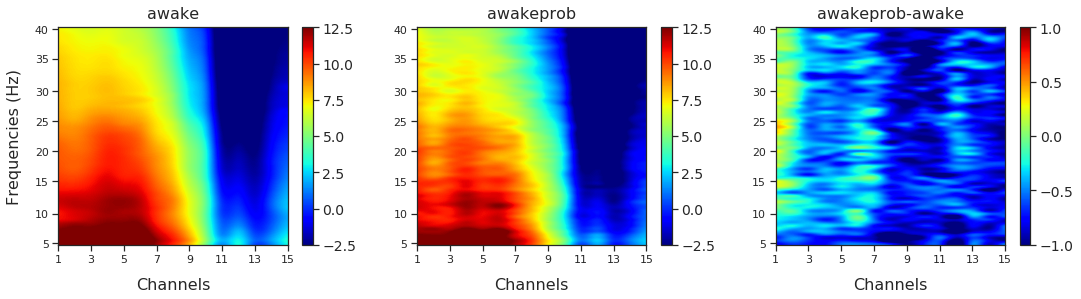

In [30]:
fig = plt.figure(figsize=(6*3, 4))
gs_main = gridspec.GridSpec(1, 3,width_ratios=[4,4,4])
gs_main.update(wspace=0.25, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])
ax1 = plot_spect(group_cat1mean, ax = ax1, x = np.arange(0,group_cat1.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)', title = cat_state[0],
                 vmin = -2.5, vmax = 12.5) #vmin = -3, vmax = 13

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])
ax2 = fig.add_subplot(gs[0])
ax2 = plot_spect(group_cat2mean, ax = ax2, x = np.arange(0,group_cat2.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = '', title = cat_state[1],
                 vmin = -2.5, vmax = 12.5) #vmin = -3, vmax = 13

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[2])
ax3 = fig.add_subplot(gs[0])
ax3 = plot_spect(diff_groupmean, ax = ax3, x = np.arange(0,diff_group.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = '', title = cat_state[1] + '-' + cat_state[0],
                 vmin = -1, vmax = 1) #vmin = -1, vmax = 1, vmin = -6, vmax = 6

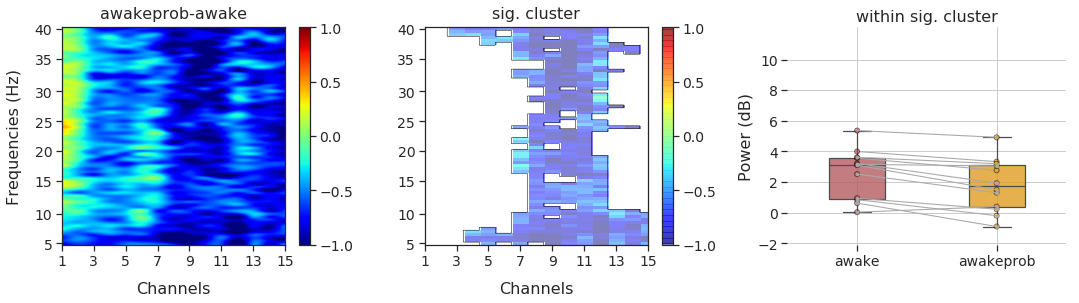

In [31]:
fig = plt.figure(figsize=(6*3, 4))
gs_main = gridspec.GridSpec(1, 3,width_ratios=[4,4,4])
gs_main.update(wspace=0.30, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])
ax1 = plot_spect(diff_groupmean, ax = ax1, x = np.arange(0,diff_group.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)', title = cat_state[1] + '-' + cat_state[0],
                 vmin = -1, vmax = 1) #vmin = -0.5, vmax = 2, vmin = -1, vmax = 1, vmin = -6, vmax = 6


ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])
ax2 = fig.add_subplot(gs[0])
ax2 = plot_clustermask(diff_groupmean, ax = ax2, x = np.arange(0,diff_group.shape[2]), y = cat_freqs,
                       x_label = 'Channels', y_label = '', title = 'sig. cluster',
                       contourmask = contourmask, mask = mask, 
                       vmin = -1, vmax = 1)#vmin = -1, vmax = 1,vmin = -0.5, vmax = 2

ax2.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[2])

if ~mask_empty:

    ax3 = fig.add_subplot(gs[0])
    sns.boxplot(x="type",y="power",data = group_roi_df, whis=np.inf, ax=ax3, showbox=True,dodge=False,
                meanline=True,showmeans=False, showfliers=True,showcaps=True, width = 0.4,
                linewidth = 1.25, palette = typepal)

    sns.pointplot(x="type",y="power",hue='dataset',data=group_roi_df,ax=ax3, dodge=0.0,
                        palette=['darkgray'])

    sns.stripplot(x="type",y="power",data = group_roi_df, jitter=False, linewidth=1, ax=ax3,
                  edgecolor ="black",palette=typepal, s= 5, alpha = 0.5)
    
    ax3.grid(True)

 
    ax3.legend_.remove()
    b = list(ax3.get_children())

    for patch in ax3.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .8))
        
    ax3.set_ylabel('Power (dB)', fontsize=label_fontsize)
    ax3.set_xlabel('', fontsize=label_fontsize)
    ax3.set_title('within sig. cluster', fontsize=label_fontsize)
    ax3.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
    
ax3.set_ylim([-2.1, 12.1])
ax3.set_yticks([-2, 0, 2, 4, 6, 8, 10])
# plt.tight_layout()
plt.box(False)

## sleep vs sleepprob

In [32]:
probosciscat = 'sleepprob'
controlcat = 'sleep' 
figstrg = 'sleepprob_sleep'

In [33]:
diff_group, n_subjects, group_cat1mean, group_cat2mean, diff_groupmean, group_cat1,\
group_cat2, cat_state, cat_freqs = computegrpdiff_withinstates(probosciscat,controlcat)

Processing:  27072018_SponSleep_LFP
Cat1:  sleep  -- size: 10435
Cat2:  sleepprob  -- size: 872
Processing:  14092018_SponSleep_LFP
Cat1:  sleep  -- size: 10140
Cat2:  sleepprob  -- size: 88
Processing:  17092018_SponSleep_LFP
Cat1:  sleep  -- size: 15701
Cat2:  sleepprob  -- size: 129
Processing:  30102018_SponSleep_LFP
Cat1:  sleep  -- size: 6952
Cat2:  sleepprob  -- size: 295
Processing:  01112018_SponSleep_LFP
Skipping: 01112018_SponSleep_LFP
Processing:  03112018_SponSleep_LFP
Cat1:  sleep  -- size: 10777
Cat2:  sleepprob  -- size: 185
Processing:  13112018_SponSleep_LFP
Cat1:  sleep  -- size: 11700
Cat2:  sleepprob  -- size: 258
Processing:  28112018_SponSleep_LFP
Skipping: 28112018_SponSleep_LFP
Processing:  11122018_SponSleep_LFP
Cat1:  sleep  -- size: 4490
Cat2:  sleepprob  -- size: 77
Processing:  10012019_SponSleep_LFP
Cat1:  sleep  -- size: 3356
Cat2:  sleepprob  -- size: 322
Processing:  17012019_SponSleep_LFP
Cat1:  sleep  -- size: 6680
Cat2:  sleepprob  -- size: 443
Proc

In [34]:
contourmask, contourmask2, mask = computestats(diff_group, n_subjects)

(11, 73, 15)
(11, 73, 15)
(11, 1095)
(15, 15)
stat_fun(H1): min=-2.395466 max=5.346034
Running initial clustering
Found 19 clusters
Permuting 1022 times...



Computing cluster p-values
Done.


In [35]:
group_roi_df, group_roi_cat1, group_roi_cat2, typepal = computegrproi_withinstates(probosciscat, controlcat,
                                                                                   contourmask2)

Processing:  27072018_SponSleep_LFP
Processing:  14092018_SponSleep_LFP
Processing:  17092018_SponSleep_LFP
Processing:  30102018_SponSleep_LFP
Processing:  01112018_SponSleep_LFP
Skipping: 01112018_SponSleep_LFP
Processing:  03112018_SponSleep_LFP
Processing:  13112018_SponSleep_LFP
Processing:  28112018_SponSleep_LFP
Skipping: 28112018_SponSleep_LFP
Processing:  11122018_SponSleep_LFP
Processing:  10012019_SponSleep_LFP
Processing:  17012019_SponSleep_LFP
Processing:  22012019_SponSleep_LFP
Processing:  20022019_SponSleep_LFP


In [36]:
group_roi_df['dataset'] = group_roi_df.index
group_roi_df = group_roi_df.melt(id_vars=["dataset"], var_name="type", value_name="power")

In [37]:
mask_empty = np.all((contourmask == 0))
mask_empty

False

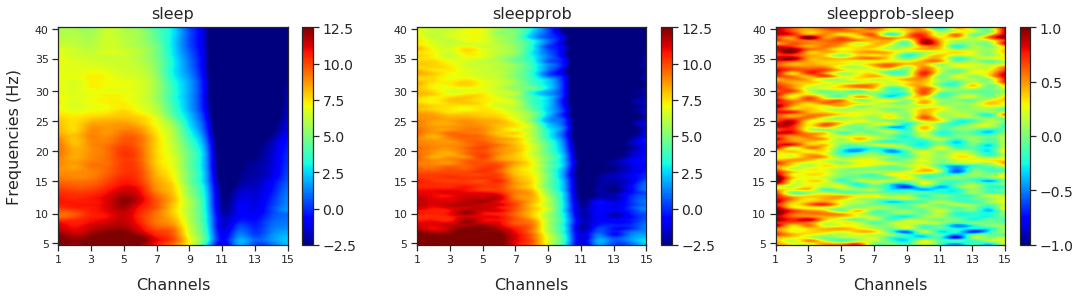

In [38]:
fig = plt.figure(figsize=(6*3, 4))
gs_main = gridspec.GridSpec(1, 3,width_ratios=[4,4,4])
gs_main.update(wspace=0.25, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])
ax1 = plot_spect(group_cat1mean, ax = ax1, x = np.arange(0,group_cat1.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)', title = cat_state[0],
                 vmin = -2.5, vmax = 12.5) #vmin = -3, vmax = 13

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])
ax2 = fig.add_subplot(gs[0])
ax2 = plot_spect(group_cat2mean, ax = ax2, x = np.arange(0,group_cat2.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = '', title = cat_state[1],
                 vmin = -2.5, vmax = 12.5) #vmin = -3, vmax = 13

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[2])
ax3 = fig.add_subplot(gs[0])
ax3 = plot_spect(diff_groupmean, ax = ax3, x = np.arange(0,diff_group.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = '', title = cat_state[1] + '-' + cat_state[0],
                 vmin = -1, vmax = 1) #vmin = -1, vmax = 1, vmin = -6, vmax = 6

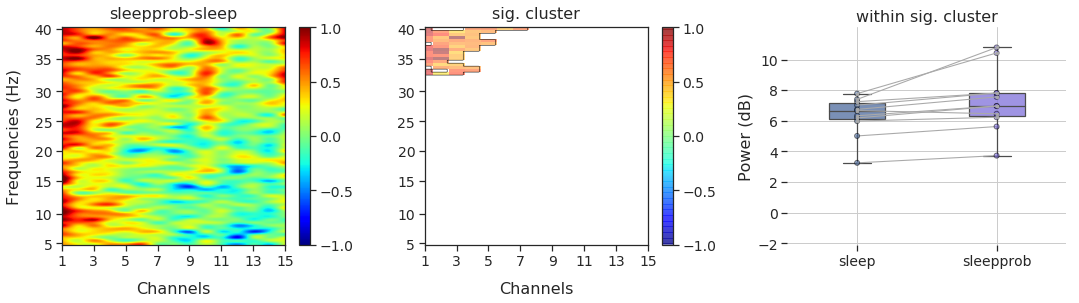

In [39]:
fig = plt.figure(figsize=(6*3, 4))
gs_main = gridspec.GridSpec(1, 3,width_ratios=[4,4,4])
gs_main.update(wspace=0.30, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])
ax1 = plot_spect(diff_groupmean, ax = ax1, x = np.arange(0,diff_group.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)', title = cat_state[1] + '-' + cat_state[0],
                 vmin = -1, vmax = 1) #vmin = -0.5, vmax = 2, vmin = -1, vmax = 1, vmin = -6, vmax = 6


ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])
ax2 = fig.add_subplot(gs[0])
ax2 = plot_clustermask(diff_groupmean, ax = ax2, x = np.arange(0,diff_group.shape[2]), y = cat_freqs,
                       x_label = 'Channels', y_label = '', title = 'sig. cluster',
                       contourmask = contourmask, mask = mask, 
                       vmin = -1, vmax = 1)#vmin = -1, vmax = 1,vmin = -0.5, vmax = 2

ax2.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[2])

if ~mask_empty:

    ax3 = fig.add_subplot(gs[0])
    sns.boxplot(x="type",y="power",data = group_roi_df, whis=np.inf, ax=ax3, showbox=True,dodge=False,
                meanline=True,showmeans=False, showfliers=True,showcaps=True, width = 0.4,
                linewidth = 1.25, palette = typepal)

    sns.pointplot(x="type",y="power",hue='dataset',data=group_roi_df,ax=ax3, dodge=0.0,
                        palette=['darkgray'])

    sns.stripplot(x="type",y="power",data = group_roi_df, jitter=False, linewidth=1, ax=ax3,
                  edgecolor ="black",palette=typepal, s= 5, alpha = 0.5)
    
    ax3.grid(True)

 
    ax3.legend_.remove()
    b = list(ax3.get_children())

    for patch in ax3.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .8))
        
    ax3.set_ylabel('Power (dB)', fontsize=label_fontsize)
    ax3.set_xlabel('', fontsize=label_fontsize)
    ax3.set_title('within sig. cluster', fontsize=label_fontsize)
    ax3.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
    
ax3.set_ylim([-2.1, 12.1])
ax3.set_yticks([-2, 0, 2, 4, 6, 8, 10])
# plt.tight_layout()
plt.box(False)

## awakeprob vs sleepprob

In [40]:
probosciscat = None
controlcat = ['awake','sleep']
figstrg = '_1sec_awakevssleep'

In [41]:
diff_list, group_cat1, group_cat2, group_cat1size, group_cat2size, cat_state,cat_freqs =\
                                   computegrp_withinstates(probosciscat, controlcat)

Processing:  27072018_SponSleep_LFP
Cat1:  sleep  -- size: 10435
Cat2:  awake  -- size: 14767
Processing:  14092018_SponSleep_LFP
Cat1:  sleep  -- size: 10140
Cat2:  awake  -- size: 15672
Processing:  17092018_SponSleep_LFP
Cat1:  sleep  -- size: 15701
Cat2:  awake  -- size: 10697
Processing:  30102018_SponSleep_LFP
Cat1:  sleep  -- size: 6952
Cat2:  awake  -- size: 20315
Processing:  01112018_SponSleep_LFP
Cat1:  sleep  -- size: 5560
Cat2:  awake  -- size: 22037
Processing:  03112018_SponSleep_LFP
Cat1:  sleep  -- size: 10777
Cat2:  awake  -- size: 16742
Processing:  13112018_SponSleep_LFP
Cat1:  sleep  -- size: 11700
Cat2:  awake  -- size: 15549
Processing:  28112018_SponSleep_LFP
Cat1:  sleep  -- size: 1123
Cat2:  awake  -- size: 26452
Processing:  11122018_SponSleep_LFP
Cat1:  sleep  -- size: 4490
Cat2:  awake  -- size: 21690
Processing:  10012019_SponSleep_LFP
Cat1:  sleep  -- size: 3356
Cat2:  awake  -- size: 24210
Processing:  17012019_SponSleep_LFP
Cat1:  sleep  -- size: 6680
C

In [42]:
probosciscat = ['awakeprob','sleepprob']
controlcat = None
figstrg = 'awakeprob_sleepprob'

In [43]:
probosciscat1 = 'sleepprob'
controlcat1 = 'sleep' 
probosciscat2 = 'awakeprob'
controlcat2 = 'awake'
figstrg = 'awakeprob_sleepprob'

diff_group, n_subjects, group_cat1mean, group_cat2mean, diff_groupmean, group_cat1,\
group_cat2, cat_state, cat_freqs = computegrpdiff_acrossstates(probosciscat1, controlcat1,\
                                                               probosciscat2, controlcat2)

Processing:  27072018_SponSleep_LFP
Cat1:  sleepprob  -- size: 10435
Cat2:  awakeprob  -- size: 14767
Processing:  14092018_SponSleep_LFP
Cat1:  sleepprob  -- size: 10140
Cat2:  awakeprob  -- size: 15672
Processing:  17092018_SponSleep_LFP
Cat1:  sleepprob  -- size: 15701
Cat2:  awakeprob  -- size: 10697
Processing:  30102018_SponSleep_LFP
Cat1:  sleepprob  -- size: 6952
Cat2:  awakeprob  -- size: 20315
Processing:  01112018_SponSleep_LFP
Skipping: 01112018_SponSleep_LFP
Processing:  03112018_SponSleep_LFP
Skipping: 03112018_SponSleep_LFP
Processing:  13112018_SponSleep_LFP
Cat1:  sleepprob  -- size: 11700
Cat2:  awakeprob  -- size: 15549
Processing:  28112018_SponSleep_LFP
Skipping: 28112018_SponSleep_LFP
Processing:  11122018_SponSleep_LFP
Cat1:  sleepprob  -- size: 4490
Cat2:  awakeprob  -- size: 21690
Processing:  10012019_SponSleep_LFP
Cat1:  sleepprob  -- size: 3356
Cat2:  awakeprob  -- size: 24210
Processing:  17012019_SponSleep_LFP
Cat1:  sleepprob  -- size: 6680
Cat2:  awakepr

In [44]:
contourmask, contourmask2, mask = computestats(diff_group, n_subjects)

(10, 73, 15)
(10, 73, 15)
(10, 1095)
(15, 15)
stat_fun(H1): min=-1.196565 max=11.409272
Running initial clustering
Found 11 clusters
Permuting 510 times...



Computing cluster p-values
Done.


In [45]:
group_roi_df, group_roi_cat1, group_roi_cat2, typepal = computegrproi_acrossstates(probosciscat1, controlcat1,
                                                                      probosciscat2, controlcat2)

Processing:  27072018_SponSleep_LFP
Processing:  14092018_SponSleep_LFP
Processing:  17092018_SponSleep_LFP
Processing:  30102018_SponSleep_LFP
Processing:  01112018_SponSleep_LFP
Skipping: 01112018_SponSleep_LFP
Processing:  03112018_SponSleep_LFP
Skipping: 03112018_SponSleep_LFP
Processing:  13112018_SponSleep_LFP
Processing:  28112018_SponSleep_LFP
Skipping: 28112018_SponSleep_LFP
Processing:  11122018_SponSleep_LFP
Processing:  10012019_SponSleep_LFP
Processing:  17012019_SponSleep_LFP
Processing:  22012019_SponSleep_LFP
Processing:  20022019_SponSleep_LFP


In [46]:
group_roi_df['dataset'] = group_roi_df.index
group_roi_df = group_roi_df.melt(id_vars=["dataset"], var_name="type", value_name="power")

In [47]:
mask_empty = np.all((contourmask == 0))
mask_empty

False

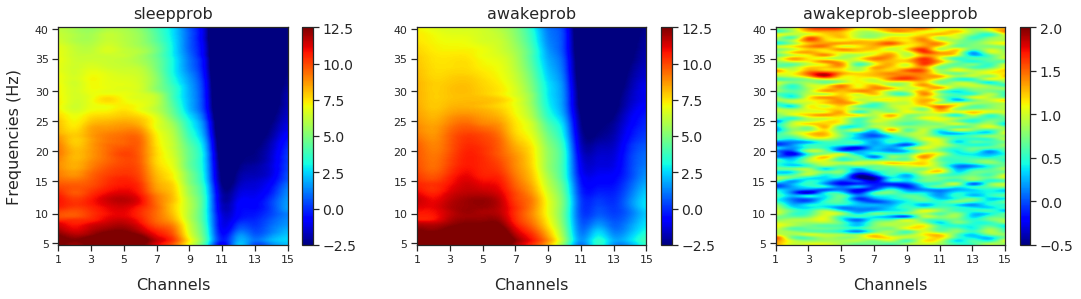

In [48]:
fig = plt.figure(figsize=(6*3, 4))
gs_main = gridspec.GridSpec(1, 3,width_ratios=[4,4,4])
gs_main.update(wspace=0.25, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])
ax1 = plot_spect(group_cat1mean, ax = ax1, x = np.arange(0,group_cat1.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)', title = cat_state[0],
                 vmin = -2.5, vmax = 12.5) #vmin = -3, vmax = 13

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])
ax2 = fig.add_subplot(gs[0])
ax2 = plot_spect(group_cat2mean, ax = ax2, x = np.arange(0,group_cat2.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = '', title = cat_state[1],
                 vmin = -2.5, vmax = 12.5) #vmin = -3, vmax = 13

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[2])
ax3 = fig.add_subplot(gs[0])
ax3 = plot_spect(diff_groupmean, ax = ax3, x = np.arange(0,diff_group.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = '', title = cat_state[1] + '-' + cat_state[0],
                 vmin = -0.5, vmax = 2) #vmin = -1, vmax = 1, vmin = -6, vmax = 6

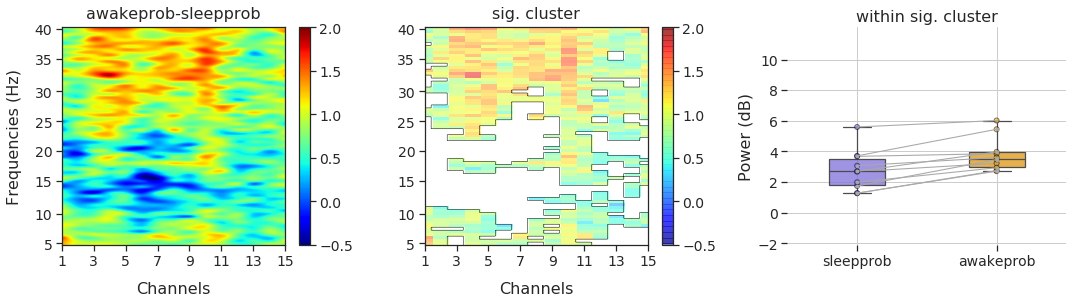

In [49]:
fig = plt.figure(figsize=(6*3, 4))
gs_main = gridspec.GridSpec(1, 3,width_ratios=[4,4,4])
gs_main.update(wspace=0.30, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])
ax1 = plot_spect(diff_groupmean, ax = ax1, x = np.arange(0,diff_group.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)', title = cat_state[1] + '-' + cat_state[0],
                 vmin = -0.5, vmax = 2)


ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])
ax2 = fig.add_subplot(gs[0])
ax2 = plot_clustermask(diff_groupmean, ax = ax2, x = np.arange(0,diff_group.shape[2]), y = cat_freqs,
                       x_label = 'Channels', y_label = '', title = 'sig. cluster',
                       contourmask = contourmask, mask = mask, 
                       vmin = -0.5, vmax = 2)

ax2.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[2])

if ~mask_empty:

    ax3 = fig.add_subplot(gs[0])
    sns.boxplot(x="type",y="power",data = group_roi_df, whis=np.inf, ax=ax3, showbox=True,dodge=False,
                meanline=True,showmeans=False, showfliers=True,showcaps=True, width = 0.4,
                linewidth = 1.25, palette = typepal)

    sns.pointplot(x="type",y="power",hue='dataset',data=group_roi_df,ax=ax3, dodge=0.0,
                        palette=['darkgray'])

    sns.stripplot(x="type",y="power",data = group_roi_df, jitter=False, linewidth=1, ax=ax3,
                  edgecolor ="black",palette=typepal, s= 5, alpha = 0.5)
    
    ax3.grid(True)

 
    ax3.legend_.remove()
    b = list(ax3.get_children())

    for patch in ax3.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .8))
        
    ax3.set_ylabel('Power (dB)', fontsize=label_fontsize)
    ax3.set_xlabel('', fontsize=label_fontsize)
    ax3.set_title('within sig. cluster', fontsize=label_fontsize)
    ax3.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
    
ax3.set_ylim([-2.1, 12.1])
ax3.set_yticks([-2, 0, 2, 4, 6, 8, 10])
# plt.tight_layout()
plt.box(False)